## Import dependencies

In [1]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
%tensorflow_version  2.x

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.13
Tensorflow version: 2.8.0
Keras version: 2.8.0


## Download the dataset

[Wikipedia](https://www.tensorflow.org/datasets/catalog/wikipedia) dataset contains cleaned articles of all languages. The datasets are built from the [Wikipedia dump](https://dumps.wikimedia.org/) with one split per language. Each example contains the content of one full Wikipedia article with cleaning to strip markdown and unwanted sections (references, etc.).

In [3]:
# List all available datasets to see how the wikipedia dataset is called.
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

In [4]:
# Loading the wikipedia dataset.
DATASET_NAME = 'wikipedia/20190301.en'
# DATASET_NAME = 'wikipedia/20190301.uk'

dataset, dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    split=tfds.Split.TRAIN,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/258 [00:00<?, ? file/s]


Dataset wikipedia downloaded and prepared to tmp/wikipedia/20190301.en/1.0.0. Subsequent calls will reuse this data.


In [5]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='wikipedia',
    version=1.0.0,
    description='Wikipedia dataset containing cleaned articles of all languages.
The datasets are built from the Wikipedia dump
(https://dumps.wikimedia.org/) with one split per language. Each example
contains the content of one full Wikipedia article with cleaning to strip
markdown and unwanted sections (references, etc.).',
    homepage='https://dumps.wikimedia.org',
    features=FeaturesDict({
        'text': Text(shape=(), dtype=tf.string),
        'title': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=5824596,
    splits={
        'train': 5824596,
    },
    supervised_keys=None,
    citation="""@ONLINE {wikidump,
        author = "Wikimedia Foundation",
        title  = "Wikimedia Downloads",
        url    = "https://dumps.wikimedia.org"
    }""",
    redistribution_info=license: "This work is licensed under the Creative Commons Attribution-ShareAlike 3.0 Unported License. To view a copy of this l

In [6]:
print(dataset)

<PrefetchDataset element_spec={'text': TensorSpec(shape=(), dtype=tf.string, name=None), 'title': TensorSpec(shape=(), dtype=tf.string, name=None)}>


## Analyze the dataset

In [7]:
TRAIN_NUM_EXAMPLES = dataset_info.splits['train'].num_examples
print('Total number of articles: ', TRAIN_NUM_EXAMPLES)

Total number of articles:  5824596


In [8]:
print('First article','\n======\n')
for example in dataset.take(1):
    print('Title:','\n------')
    print(example['title'].numpy().decode('utf-8'))
    print()

    print('Text:', '\n------')
    print(example['text'].numpy().decode('utf-8'))

First article 

Title: 
------
Joseph Greenberg

Text: 
------
Joseph Harold Greenberg (May 28, 1915 – May 7, 2001) was an American linguist, known mainly for his work concerning linguistic typology and the genetic classification of languages.

Life

Early life and education 
(Main source: Croft 2003)

Joseph Greenberg was born on May 28, 1915 to Jewish parents in Brooklyn, New York. His first great interest was music. At the age of 14, he gave a piano concert in Steinway Hall. He continued to play the piano frequently throughout his life.

After finishing high school, he decided to pursue a scholarly career rather than a musical one. He enrolled at Columbia University in New York. During his senior year, he attended a class taught by Franz Boas concerning American Indian languages. With references from Boas and Ruth Benedict, he was accepted as a graduate student by Melville J. Herskovits at Northwestern University in Chicago. During the course of his graduate studies, Greenberg did f

## Process the dataset

### Flatten the dataset

Converting the dataset from the set of articles into the set of characters. 

In [9]:
def article_to_text(text):
    return np.array([char for char in text.numpy().decode('utf-8')])

# Converting each dataset item to a string ('text') instead of a dictionary ({'text', 'title'}).
dataset_text = dataset.map(
    lambda article: tf.py_function(func=article_to_text, inp=[article['text']], Tout=tf.string)
)

for text in dataset_text.take(2):
    print(text.numpy())
    print('\n')

[b'J' b'o' b's' ... b'n' b't' b's']


[b'P' b'a' b'u' ... b'e' b'r' b's']




In [10]:
# Unbatch the text dataset into a more granular char dataset.
# Now each dataset item is one character instead of a big piece of text.
dataset_chars = dataset_text.unbatch()

for char in dataset_chars.take(20):
    print(char.numpy().decode('utf-8'))

J
o
s
e
p
h
 
H
a
r
o
l
d
 
G
r
e
e
n
b


### Generating vocabulary

In [11]:
vocab = set()

# Ideally we should take all dataset items into account here.
for text in dataset_text.take(1000):
    vocab.update([char.decode('utf-8') for char in text.numpy()])
    
vocab = sorted(vocab)

print('Unique characters: {}'.format(len(vocab)))
print('vocab:')
print(vocab)

Unique characters: 621
vocab:
['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\xa0', '£', '§', '«', '®', '°', '±', '²', '·', '»', '¼', '½', '¿', 'Á', 'Å', 'Æ', 'Ç', 'É', 'Ë', 'Í', 'Î', 'Ó', 'Ö', '×', 'Ø', 'Ü', 'Þ', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', 'ø', 'ú', 'û', 'ü', 'ý', 'ā', 'ă', 'ą', 'Ć', 'ć', 'Č', 'č', 'đ', 'ė', 'ę', 'ě', 'ğ', 'ġ', 'Ħ', 'ī', 'İ', 'ı', 'ļ', 'Ł', 'ł', 'ń', 'ň', 'Ō', 'ō', 'ő', 'ř', 'Ś', 'ś', 'Ş', 'ş', 'Š', 'š', 'ţ', 'ū', 'ź', 'ż', 'Ž', 'ž', 'ơ', 'ư', 'ǔ', 'ș',

### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [12]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(30)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\t':   0,
  '\n':   1,
  ' ' :   2,
  '!' :   3,
  '"' :   4,
  '#' :   5,
  '$' :   6,
  '%' :   7,
  '&' :   8,
  "'" :   9,
  '(' :  10,
  ')' :  11,
  '*' :  12,
  '+' :  13,
  ',' :  14,
  '-' :  15,
  '.' :  16,
  '/' :  17,
  '0' :  18,
  '1' :  19,
  '2' :  20,
  '3' :  21,
  '4' :  22,
  '5' :  23,
  '6' :  24,
  '7' :  25,
  '8' :  26,
  '9' :  27,
  ':' :  28,
  ';' :  29,
  ...
}


In [13]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)

print(index2char)

['\t' '\n' ' ' '!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/'
 '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' ':' ';' '<' '=' '>' '?' '@' 'A'
 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S'
 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' '[' ']' '^' '_' '`' 'a' 'b' 'c' 'd' 'e' 'f'
 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x'
 'y' 'z' '{' '|' '}' '~' '\xa0' '£' '§' '«' '®' '°' '±' '²' '·' '»' '¼'
 '½' '¿' 'Á' 'Å' 'Æ' 'Ç' 'É' 'Ë' 'Í' 'Î' 'Ó' 'Ö' '×' 'Ø' 'Ü' 'Þ' 'ß' 'à'
 'á' 'â' 'ã' 'ä' 'å' 'æ' 'ç' 'è' 'é' 'ê' 'ë' 'ì' 'í' 'î' 'ï' 'ñ' 'ò' 'ó'
 'ô' 'õ' 'ö' 'ø' 'ú' 'û' 'ü' 'ý' 'ā' 'ă' 'ą' 'Ć' 'ć' 'Č' 'č' 'đ' 'ė' 'ę'
 'ě' 'ğ' 'ġ' 'Ħ' 'ī' 'İ' 'ı' 'ļ' 'Ł' 'ł' 'ń' 'ň' 'Ō' 'ō' 'ő' 'ř' 'Ś' 'ś'
 'Ş' 'ş' 'Š' 'š' 'ţ' 'ū' 'ź' 'ż' 'Ž' 'ž' 'ơ' 'ư' 'ǔ' 'ș' 'ț' 'ɔ' 'ə' 'ɛ'
 'ʷ' 'ʼ' 'ʿ' '˚' 'Ι' 'Π' 'α' 'β' 'ε' 'η' 'ι' 'κ' 'μ' 'ο' 'ρ' 'ς' 'τ' 'υ'
 'χ' 'ψ' 'ό' 'Б' 'В' 'Д' 'Ж' 'З' 'И' 'К' 'Л' 'М' 'Н' 'О' 'П' 'С' 'У' 'Ф'
 'Х' 'а' 'б' 'в' 'г' 'д' 'е' 'з' 'и' 'й' 'к' 'л' '

In [14]:
def char_to_index(char):
    char_symbol = char.numpy().decode('utf-8')
    char_index = char2index[char_symbol] if char_symbol in char2index else char2index['?']
    return char_index

dataset_chars_indexed = dataset_chars.map(
    lambda char: tf.py_function(func=char_to_index, inp=[char], Tout=tf.int32)
)

print('ORIGINAL CHARS:', '\n---')
for char in dataset_chars.take(10):
    print(char.numpy().decode())

print('\n\n')    
    
print('INDEXED CHARS:', '\n---')
for char_index in dataset_chars_indexed.take(20):
    print(char_index.numpy())

ORIGINAL CHARS: 
---
J
o
s
e
p
h
 
H
a
r



INDEXED CHARS: 
---
44
80
84
70
81
73
2
42
66
83
80
77
69
2
41
83
70
70
79
67


## Create training sequences

In [15]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 200

In [16]:
# Generate batched sequences out of the char_dataset.
sequences = dataset_chars_indexed.batch(sequence_length + 1, drop_remainder=True)

# Sequences examples.
for item in sequences.take(10):
    print(repr(''.join(index2char[item.numpy()])))
    print()

'Joseph Harold Greenberg (May 28, 1915 – May 7, 2001) was an American linguist, known mainly for his work concerning linguistic typology and the genetic classification of languages.\n\nLife\n\nEarly life an'

'd education \n(Main source: Croft 2003)\n\nJoseph Greenberg was born on May 28, 1915 to Jewish parents in Brooklyn, New York. His first great interest was music. At the age of 14, he gave a piano concert '

'in Steinway Hall. He continued to play the piano frequently throughout his life.\n\nAfter finishing high school, he decided to pursue a scholarly career rather than a musical one. He enrolled at Columbia'

' University in New York. During his senior year, he attended a class taught by Franz Boas concerning American Indian languages. With references from Boas and Ruth Benedict, he was accepted as a graduat'

'e student by Melville J. Herskovits at Northwestern University in Chicago. During the course of his graduate studies, Greenberg did fieldwork among the Hausa people of Ni

In [ ]:
# sequences shape:
# - Each sequence of length 101
#
#    201     201          201
# [(.....) (.....) ...  (.....)]

For each sequence, duplicate and shift it to form the input and target text. For example, say `sequence_length` is `4` and text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [17]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [18]:
dataset_sequences = sequences.map(split_input_target)

In [19]:
for input_example, target_example in dataset_sequences.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:\n', repr(''.join(index2char[input_example.numpy()])))
    print()
    print('Target:\n', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 200
Target sequence size: 200

Input:
 'Joseph Harold Greenberg (May 28, 1915 – May 7, 2001) was an American linguist, known mainly for his work concerning linguistic typology and the genetic classification of languages.\n\nLife\n\nEarly life a'

Target:
 'oseph Harold Greenberg (May 28, 1915 – May 7, 2001) was an American linguist, known mainly for his work concerning linguistic typology and the genetic classification of languages.\n\nLife\n\nEarly life an'


In [ ]:
# dataset shape:
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#    200       200           200
# /(.....)\ /(.....)\ ... /(.....)\  <-- input_text
# \(.....)/ \(.....)/     \(.....)/  <-- target_text

Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [20]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step #{:1d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))
    print()

Step #0
  input: 44 ('J')
  expected output: 80 ('o')

Step #1
  input: 80 ('o')
  expected output: 84 ('s')

Step #2
  input: 84 ('s')
  expected output: 70 ('e')

Step #3
  input: 70 ('e')
  expected output: 81 ('p')

Step #4
  input: 81 ('p')
  expected output: 73 ('h')



## Split training sequences into batches

Split the text into manageable sequences. But before feeding this data into the model, shuffle the data and pack it into batches.

In [21]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 100

# How many items to prefetch before the next iteration.
PREFETCH_SIZE = 10

dataset_sequence_batches = dataset_sequences \
    .shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(PREFETCH_SIZE)

dataset_sequence_batches

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

In [22]:
for input_text, target_text in dataset_sequence_batches.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 2 84 66 ... 77 78 66]
 [ 2 53 85 ... 66 85  2]
 [86 69 70 ... 37 66 79]
 ...
 [28 49 71 ... 85 83 66]
 [70 83 84 ... 74 66 85]
 [70  2 50 ... 73 70  2]], shape=(64, 200), dtype=int32)

1st batch: target_text: tf.Tensor(
[[84 66 78 ... 78 66 85]
 [53 85 70 ... 85  2 88]
 [69 70 79 ... 66 79 66]
 ...
 [49 71 71 ... 83 66 79]
 [83 84  1 ... 66 85 70]
 [ 2 50 66 ... 70  2 73]], shape=(64, 200), dtype=int32)


In [ ]:
# dataset shape:
# - 64 sequences per batch
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#     200       200           200             200       200           200
# |/(.....)\ /(.....)\ ... /(.....)\| ... |/(.....)\ /(.....)\ ... /(.....)\|  <-- input_text
# |\(.....)/ \(.....)/     \(.....)/| ... |\(.....)/ \(.....)/     \(.....)/|  <-- target_text
#
# <------------- 64 ---------------->     <------------- 64 ---------------->

## Build the model


In [23]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [24]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))
    
    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
  
    return model

In [25]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           158976    
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 621)           636525    
                                                                 
Total params: 6,042,477
Trainable params: 6,042,477
Non-trainable params: 0
_________________________________________________________________


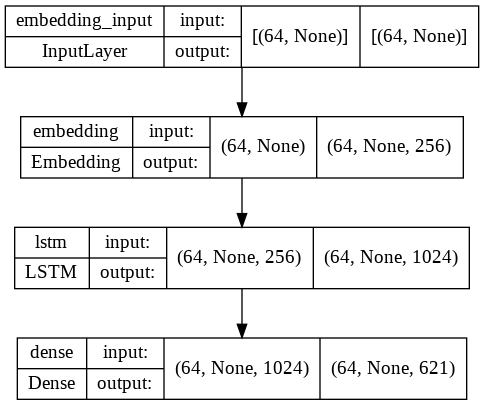

In [27]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:


## Try the model

In [28]:
for input_example_batch, target_example_batch in dataset_sequence_batches.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 200, 621) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [29]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[ 9.67553817e-04 -1.32447877e-03  4.20299266e-03 -3.07718292e-03
 -5.53964730e-03 -2.40335427e-03  4.15250426e-04 -6.05621724e-04
  1.90670879e-04 -2.55828025e-04 -5.64306043e-03 -1.93131377e-03
  1.69167004e-03 -3.21730186e-04 -1.35243870e-03  4.45078331e-04
  4.57338087e-04 -1.50511484e-03  2.34352145e-03 -1.02574646e-03
  1.36300304e-03  3.14017583e-04 -1.95305981e-03 -1.14943285e-03
  6.36739598e-04  9.97564406e-04  2.86451867e-03  5.15818654e-04
  8.94985453e-04 -4.80319548e-04 -2.23535718e-03 -6.61546539e-04
 -6.12757402e-03 -1.59340654e-03  8.81651649e-04  3.78053100e-03
  3.91772483e-03 -1.24532473e-03  3.18357162e-03 -1.20841246e-03
  4.98600816e-03  3.20875598e-03  2.48961471e-04 -3.65147949e-03
 -4.72564204e-03  7.43770215e-05 -5.60463348e-04 -1.56961242e-03
  2.48030853e-03 -1.48022163e-03 -2.60224356e-03  1.63893070e-04
 -7.44520128e-03  3.85469059e-04 -1.44548400e-03  7.37630879e-04
  3.08791175e-03  1.61

In [30]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 1 2 2 2]], shape=(1, 5), dtype=int64)


In [31]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([200, 1])

In [32]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(200,)

In [33]:
sampled_indices

array([277, 306, 150, 472, 490, 539, 509, 289,  53, 564, 127, 505, 388,
       476, 270, 218,  67, 266, 311, 200, 461, 351, 149, 372, 307,  99,
       180,  78, 473, 379, 503,  12, 347, 351, 413,  77, 180,  26, 497,
        74, 533, 407, 465, 453, 541, 325, 334, 210, 610, 266, 158, 315,
       500, 550, 478,  23, 462, 479, 220, 354, 550, 366, 551,  94, 220,
       301, 293, 549, 616, 355, 248,  69,  20, 199, 355, 191, 411, 126,
       321, 252, 226, 384, 358, 342, 258, 209,  57,  53, 181, 606, 357,
       201, 377, 449, 351, 157, 560, 125, 315, 608, 167, 249,   0, 618,
       417, 595, 449,  95, 579, 400,  21, 571,  92, 617, 471, 457, 306,
       325, 322, 290,  98, 488, 495, 109, 288, 337, 123, 395, 366, 562,
       251, 541, 545, 433,  21, 383, 137, 243,  53, 612, 501, 581,  50,
       107, 194, 583, 170, 569, 475, 302, 104, 101, 137,  85, 396, 480,
       284,  88, 324, 406, 170, 236, 357, 140, 137, 405, 228, 143, 123,
       306, 475, 540, 593, 597,  20, 476,  26, 122, 358, 448, 40

In [34]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 'tance from an earlier common ancestor rather than being explained by a combination of errors, accidental similarity, excessive semantic latitude in comparisons, borrowings, onomatopoeia, etc.\n\nThe lan'

Next char prediction:
 'נقý児史普寄إS磨ã孤้其גБbћو˚义ชüหل«şm全ี姚*ขช′lş8國i方“介ー本பிο食ћđஅ坪法况5九前Дด法ร泥}Дشت江준ตпd2ʿตǔ•âணуМแนರщμWSŠ镇ธΙำョชč界áஅ門ıр\tﬂ₱达ョ~薦ệ3育{태光下قபதا§双哪Áأைßṟร石т本桦カ3เíкS马堡虚P½ɔ装ł義兴ص·°ítṣ加רwன’łвธñí‘Оôßق兴會辞通2其8Þนャ—å~ไ^¿ễ澤پ董コ!й児ş民ṣ>ャ₱'


In [35]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    print('Prediction #{:1d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))
    print()

Prediction #0
  input: 85 ('t')
  next predicted: 73 ('נ')

Prediction #1
  input: 66 ('a')
  next predicted: 73 ('ق')

Prediction #2
  input: 79 ('n')
  next predicted: 73 ('ý')

Prediction #3
  input: 68 ('c')
  next predicted: 73 ('児')

Prediction #4
  input: 70 ('e')
  next predicted: 73 ('史')



## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

In [36]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 200, 621)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       6.431178


In [37]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Execute the training

In [38]:
EPOCHS=150
STEPS_PER_EPOCH = 10

In [39]:
tmp_dataset = dataset_sequence_batches.repeat()
    
history = model.fit(
    x=tmp_dataset.as_numpy_iterator(),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH
    
)

Epoch 1/150
10/10 [==============================] - 33s 3s/step - loss: 4.3816
Epoch 2/150
10/10 [==============================] - 33s 3s/step - loss: 3.3779
Epoch 3/150
10/10 [==============================] - 33s 3s/step - loss: 3.2766
Epoch 4/150
10/10 [==============================] - 32s 3s/step - loss: 3.2857
Epoch 5/150
10/10 [==============================] - 33s 3s/step - loss: 3.1747
Epoch 6/150
10/10 [==============================] - 32s 3s/step - loss: 3.0932
Epoch 7/150
10/10 [==============================] - 32s 3s/step - loss: 3.0513
Epoch 8/150
10/10 [==============================] - 32s 3s/step - loss: 2.9807
Epoch 9/150
10/10 [==============================] - 32s 3s/step - loss: 2.9098
Epoch 10/150
10/10 [==============================] - 32s 3s/step - loss: 2.9249
Epoch 11/150
10/10 [==============================] - 32s 3s/step - loss: 3.0286
Epoch 12/150
10/10 [==============================] - 32s 3s/step - loss: 2.7936
Epoch 13/150
10/10 [=================

In [40]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

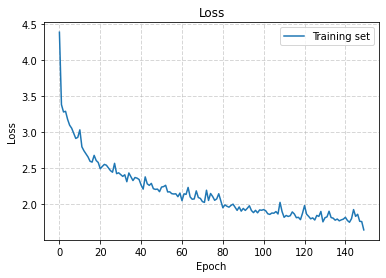

In [41]:
render_training_history(history)

In [49]:
import math
print("BPC:"+ str(1.6417 / math.log(2)))

BPC:2.3684724486274114


## Generate text

In [42]:
simplified_batch_size = 1

restored_model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

restored_model.set_weights(model.get_weights())

restored_model.build(tf.TensorShape([simplified_batch_size, None]))

In [43]:
restored_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            158976    
                                                                 
 lstm_1 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_1 (Dense)             (1, None, 621)            636525    
                                                                 
Total params: 6,042,477
Trainable params: 6,042,477
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

- Get the prediction distribution of the next character using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

In [44]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [45]:
num_generate = 300
temperatures = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
start_string = 'Science is'

for temperature in temperatures:
    print("Temperature: {}".format(temperature))
    print('---')
    print(generate_text(restored_model, start_string, num_generate=num_generate, temperature=temperature))
    print('\n')

Temperature: 0.2
---
Science is a series of the competition of the program and the time of the transport of the served and the competitors of the three the the present of the control of the town the program of the program of the the terring the track the track the first served the transing the time of the competitors of the the t


Temperature: 0.4
---
Science is a signal of the first of the production was a streat settle of the competition of the first part of the action of the competitors of the organian massic program to the group and state of the competitors and a special streat with the most of the time of the Marina of the March School of the Stard of


Temperature: 0.6
---
Science is reals of the elexing in the retir present from British while may the three its required the other had of twe not the second from the station of the story larger competitory of Harler (international Airprine (A Aurtroud historical and moder 1, 2009. It was presentation of the battle of Hardel Orenia


In [47]:
num_generate = 300
temperatures = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
start_string = 'What is'

for temperature in temperatures:
    print("Temperature: {}".format(temperature))
    print('---')
    print(generate_text(restored_model, start_string, num_generate=num_generate, temperature=temperature))
    print('\n')

Temperature: 0.2
---
What is a served the first the the two control of the survent of the two the control of the second the program in the term of the contember of the second the served a string program of the control of the second with the program and the program in the competitors of the control of the competition of the com


Temperature: 0.4
---
What is a second the program which assembly and the served the competition of the competition of the special sumpers of the program in the same of the respection with the month of the areas and the character of the China Carron and State of the track in the first first starts of the base the broad and the 


Temperature: 0.6
---
What is not a program from a society competited in fired by the competitor was a baseball in the sarist of the contuin the music school from the list of the sublegation and the counts of the Barrood International Armania Lational Regional Atall Brigal, 1990. The competitor of the transide present of the se


Tempera

## Save the model

In [46]:
model_name = 'wikipedia_rnn.h5'
restored_model.save(model_name, save_format='h5')